# AdTracking Fraud Detection Challange

In [6]:
# Importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.cross_validation import train_test_split

In [7]:
# Importing data
dtypes = {'ip'            : 'uint32',
          'app'           : 'uint16',
          'device'        : 'uint16',
          'os'            : 'uint16',
          'channel'       : 'uint16',
          'is_attributed' : 'uint8',
          'click_id'      : 'uint32'
          } 
#train_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
train = pd.read_csv('/../../../Volumes/Data/train.csv',skiprows=range(1,129903891), nrows=500000, dtype=dtypes)
#test = pd.read_csv("test.csv", dtype=dtypes)
print(train.shape)
train.head()

(500000, 8)


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,10777,12,1,13,245,2017-11-08 23:11:35,NaN,0
1,79909,13,1,17,477,2017-11-08 23:11:35,NaN,0
2,118647,26,1,19,121,2017-11-08 23:11:35,NaN,0
3,51541,3,1,13,452,2017-11-08 23:11:35,NaN,0
4,67548,18,1,19,134,2017-11-08 23:11:35,NaN,0


In [8]:
# Check missing data
train.apply(lambda x: sum(x.isnull()))
# attributed_time is NaN when the app isn't downloaded after clicking on the ad
# https://www.kaggle.com/pranav84/xgboost-histogram-optimized-version/code
# ==> here they don't use 'attributed_time'. What do you think?

ip                      0
app                     0
device                  0
os                      0
channel                 0
click_time              0
attributed_time    498995
is_attributed           0
dtype: int64

In [9]:
# Unique values
train.apply(lambda x: len(x.unique()))

ip                 30191
app                  172
device               156
os                   137
channel              151
click_time           825
attributed_time      924
is_attributed          2
dtype: int64

In [10]:
train.dtypes

ip                 uint32
app                uint16
device             uint16
os                 uint16
channel            uint16
click_time         object
attributed_time    object
is_attributed       uint8
dtype: object

In [11]:
# Extract day, hour and day of the week
train['hour'] = pd.to_datetime(train.click_time).dt.hour.astype('uint8')
train['day']  = pd.to_datetime(train.click_time).dt.day.astype('uint8')
train['dow']  = pd.to_datetime(train.click_time).dt.dayofweek.astype('uint8')

In [12]:
# # of clicks for each ip-day-hour combination
gp = train[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
train = train.merge(gp, on=['ip','day','hour'], how='left')
del gp

In [13]:
# # of clicks for each ip-app combination
gp = train[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train = train.merge(gp, on=['ip','app'], how='left')
del gp

In [14]:
# Count by IP APP OS
n_chans = train[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 
          'os'])[['channel']].count().reset_index().rename(columns={'channel': 'ip_app_os_count'})
train = train.merge(n_chans, on=['ip','app', 'os'], how='left')
del n_chans

In [15]:
# Added
n_chans = train[['ip','channel']].groupby(by=['ip'])[['channel']].count().reset_index().rename(columns={'channel': 'count_by_ip'})
train = train.merge(n_chans, on=['ip'], how='left')
del n_chans

# Count by IP HOUR CHANNEL
n_chans = train[['ip','hour','channel','os']].groupby(by=['ip','hour','channel'
           ])[['os']].count().reset_index().rename(columns={'os': 'ip_hour_channel'})
train = train.merge(n_chans, on=['ip','hour','channel'], how='left')
del n_chans


# Count by IP HOUR Device
n_chans = train[['ip','hour','channel','os']].groupby(by=['ip','hour','os'
           ])[['channel']].count().reset_index().rename(columns={'channel': 'ip_hour_os'})
train = train.merge(n_chans, on=['ip','hour','os'], how='left')
del n_chans


n_chans = train[['ip','hour','channel','app']].groupby(by=['ip','hour','app'
           ])[['channel']].count().reset_index().rename(columns={'channel': 'ip_hour_app'})
train = train.merge(n_chans, on=['ip','hour','app'], how='left')
del n_chans


n_chans = train[['ip','hour','channel','device']].groupby(by=['ip','hour','device'
           ])[['channel']].count().reset_index().rename(columns={'channel': 'ip_hour_device'})
train = train.merge(n_chans, on=['ip','hour','device'], how='left')
del n_chans


In [16]:
# Count the number of clicks by ip
ip_count = train.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
train = pd.merge(train, ip_count, on='ip', how='left', sort=False)
train['clicks_by_ip'] = train['clicks_by_ip'].astype('uint16')


In [21]:
# Delete columns we don't need
train.drop(['ip'], axis=1, inplace=True)
train.drop(['day'], axis=1, inplace=True)
train.drop(['click_time'], axis=1, inplace=True)
train.drop(['attributed_time'], axis=1, inplace=True)

#change features to 'uint16'
train['qty'] = train['qty'].astype('uint16')
train['ip_app_count'] = train['ip_app_count'].astype('uint16')
train['ip_app_os_count'] = train['ip_app_os_count'].astype('uint16')
train['ip_hour_channel'] = train['ip_hour_channel'].astype('uint16')
train['ip_hour_os'] = train['ip_hour_os'].astype('uint16')
train['ip_app_count'] = train['ip_app_count'].astype('uint16')
train['ip_hour_os'] = train['ip_hour_os'].astype('uint16')
train['ip_hour_app'] = train['ip_hour_app'].astype('uint16')
train['ip_hour_device'] = train['ip_hour_device'].astype('uint16')
train['count_by_ip'] = train['count_by_ip'].astype('uint16')

train.info()

ValueError: labels ['ip'] not contained in axis

In [22]:
train.head()
#print(train[train['is_attributed'] != 0])

,app,device,os,channel,is_attributed,hour,dow,qty,ip_app_count,ip_app_os_count,count_by_ip,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device,clicks_by_ip
0,12,1,13,245,0,23,2,37,15,15,37,30,29,15,37,37
1,13,1,17,477,0,23,2,223,9,1,223,6,14,9,201,223
2,26,1,19,121,0,23,2,12,1,1,12,1,10,1,12,12
3,3,1,13,452,0,23,2,48,5,1,48,2,5,5,48,48
4,18,1,19,134,0,23,2,16,1,1,16,1,11,1,15,16


In [23]:
X = train.drop('is_attributed', axis=1)
#y = pd.DataFrame(data=train['is_attributed'])
y = train['is_attributed']


print(X.shape, y.shape)

((500000, 15), (500000,))


In [24]:
# Gradient Boosting Machines
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

y_pred = gbrt.predict(X_test)
cm_gbrt = confusion_matrix(y_test, y_pred)

print('accuracy on training set: %f' % gbrt.score(X_train, y_train))
print('accuracy on test set: %f' % gbrt.score(X_test, y_test))
print(cm_gbrt)


accuracy on training set: 0.998331
accuracy on test set: 0.998080
[[124677     45]
 [   195     83]]


([<matplotlib.axis.XTick at 0x11d154b50>,
 <a list of 15 Text xticklabel objects>)

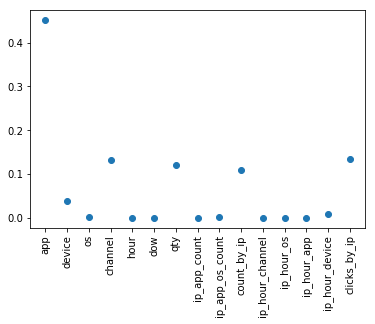

In [25]:
%matplotlib inline
plt.plot(gbrt.feature_importances_, 'o')
plt.xticks(range(X.shape[1]), X.columns.values, rotation=90)


In [26]:
# Light GBM
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)
#params = {}
#params['learning_rate'] = 0.003
#params['boosting_type'] = 'gbdt'
#params['objective'] = 'binary'
#params['metric'] = 'auc'
#params['sub_feature'] = 0.5
#params['num_leaves'] = 50
#params['min_data'] = 200
#params['max_depth'] = 50
#params['max_bin'] = 1000
#params['categorical_feature'] = '0, 1, 2, 3, 4, 5'

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.02, # was 0.05
    'num_leaves': 1400, # was 225 
    'max_depth': 3,  # was 9
    'min_child_samples': 100,  
    'max_bin': 100,  
    'subsample': 0.8, # was 0.7 
    'subsample_freq': 1,  
    'colsample_bytree': 0.9, # was 0.7
    'min_child_weight': 0,  
    'subsample_for_bin': 200000,  
    'min_split_gain': 0,  
    'reg_alpha': 0,  
    'reg_lambda': 0,  
   # 'nthread': 8,
    'verbose': 0,
    'categorical_feature': '0,1,2,3,4,5',
    'is_unbalance': True
    #'scale_pos_weight':99 
    }
clf = lgb.train(params, d_train, 1000)

/anaconda/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: categorical_feature keyword has been found in `params` and will be ignored. Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


In [27]:


#Prediction
y_pred = clf.predict(X_test)
#convert into binary values
for i in range(0, len(X_test)):
    if y_pred[i]>=.5:       # setting threshold to .5
        y_pred[i]=1
    else:  
        y_pred[i]=0


In [28]:
# classification report
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))
#Confusion matrix
from sklearn.metrics import confusion_matrix

cm_clf = confusion_matrix(y_test, y_pred)
print(cm_clf)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,y_test)
print('test: %f' % accuracy)

             precision    recall  f1-score   support

          0       1.00      0.96      0.98    124722
          1       0.04      0.78      0.08       278

avg / total       1.00      0.96      0.98    125000

[[119920   4802]
 [    61    217]]
test: 0.961096


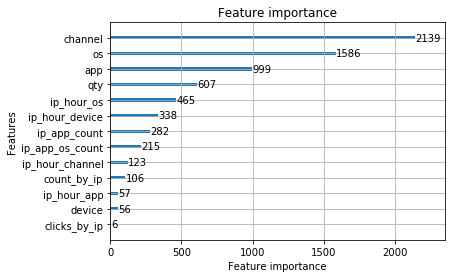

In [29]:
lgb.plot_importance(clf)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 20 columns):
ip                 500000 non-null uint32
app                500000 non-null uint16
device             500000 non-null uint16
os                 500000 non-null uint16
channel            500000 non-null uint16
click_time         500000 non-null object
attributed_time    1005 non-null object
is_attributed      500000 non-null uint8
hour               500000 non-null uint8
day                500000 non-null uint8
dow                500000 non-null uint8
qty                500000 non-null int64
ip_app_count       500000 non-null int64
ip_app_os_count    500000 non-null int64
count_by_ip        500000 non-null int64
ip_hour_channel    500000 non-null int64
ip_hour_os         500000 non-null int64
ip_hour_app        500000 non-null int64
ip_hour_device     500000 non-null int64
clicks_by_ip       500000 non-null uint16
dtypes: int64(8), object(2), uint16(5), uint32(1), uint8(4)
mem